In [12]:
# step 1: load + split data

# features:
#     HomeOdds
#     DrawOdds
#     AwayOdds
#     T_GoalsFor_H
#     T_GoalsAg_H
#     T_GoalsFor_A
#     T_GoalsAg_A
#     T_Points_H
#     T_Points_A
#     T_TablePosition_H
#     T_TablePosition_A
#     L3M_Points_H (L3M = last 3 matches)
#     L3M_Points_A

# y label (what we're predicting): goal difference

import numpy as np
import pandas as pd
import os
import datetime
import time
from utils import cleanDate

leagues = [
    'E0'
#     'D1'
#     'I1'
#     'SP1'
#     'F1'
]


def load(leagues, lossType):

    train = pd.read_csv(f'processedData/train_{leagues[0]}.csv')
    test = pd.read_csv(f'processedData/test_{leagues[0]}.csv')
    
    df = train.append(test)
    
    df.loc[:, 'Date'] = cleanDate(df.loc[:, 'Date'])
    
    dt = datetime.datetime(year=2019, month=7, day=1)
    
    df = df.loc[(df['T_GamesPlayed_H'] >= 3) & (df['T_GamesPlayed_A'] >= 3)]
    
    df = df.loc[df.loc[:,'FTR']==df.loc[:,'FTR'],:]

    ind = [i <= dt for i in df.loc[:, 'Date']]

    if lossType=='goals':
        y = df.loc[:, ['GoalsFor_H','GoalsFor_A']]

    elif lossType=='goaldif':
        y = df.loc[:, 'GoalsFor_H'] - df.loc[:, 'GoalsFor_A']

    else:
        y = df['FTR'].apply(lambda x: 2 if x == 'H' else (1 if x == 'D' else 0))

#     for i, col in enumerate(df.columns):
#         print(i, col)
        
    cols = list(range(15,18))+list(range(22,26))+list(range(34,38))+list(range(60,62))
    
    X = df.iloc[:,cols]
    
    X_train, X_test = X.loc[ind], X.loc[[i==False for i in ind]]
    y_train, y_test = y.loc[ind], y.loc[[i==False for i in ind]]
    
    train, test = df.loc[ind], df.loc[[i==False for i in ind]]
    
    return X_train, X_test, y_test, y_train, X, y, train, test, df


X_train, X_test, y_test, y_train, X, y, train, test, df = load(
    leagues=leagues, 
    lossType='goaldif'
)

X_test.tail()

HomeOdds  DrawOdds  AwayOdds  T_GoalsFor_H  T_GoalsAg_H  T_GoalsFor_A  \
325    0.1455    0.1485    0.1375      0.112500     0.140625      0.103125   
326    0.1330    0.1640    0.1370      0.103125     0.134375      0.118750   
327    0.0675    0.2725    0.4200      0.218750     0.078125      0.112500   
328    0.4515    0.2780    0.0665      0.128125     0.171875      0.253125   
329    0.1065    0.1755    0.1725      0.159375     0.137500      0.125000   

     T_GoalsAg_A  T_Points_H  T_Points_A  T_TablePosition_H  \
325     0.100000    0.468750    0.489583                 10   
326     0.175000    0.437500    0.312500                 12   
327     0.187500    0.895833    0.281250                  1   
328     0.103125    0.416667    0.687500                 14   
329     0.146875    0.468750    0.458333                 10   

     T_TablePosition_A  L3M_Points_H  L3M_Points_A  
325                  8      0.666667      0.333333  
326                 16      0.777778      0.333333  
327                 18      0.444444      0.111111  
328                  2      0.666667      0.666667  
329                 11      0.444444      0.777778

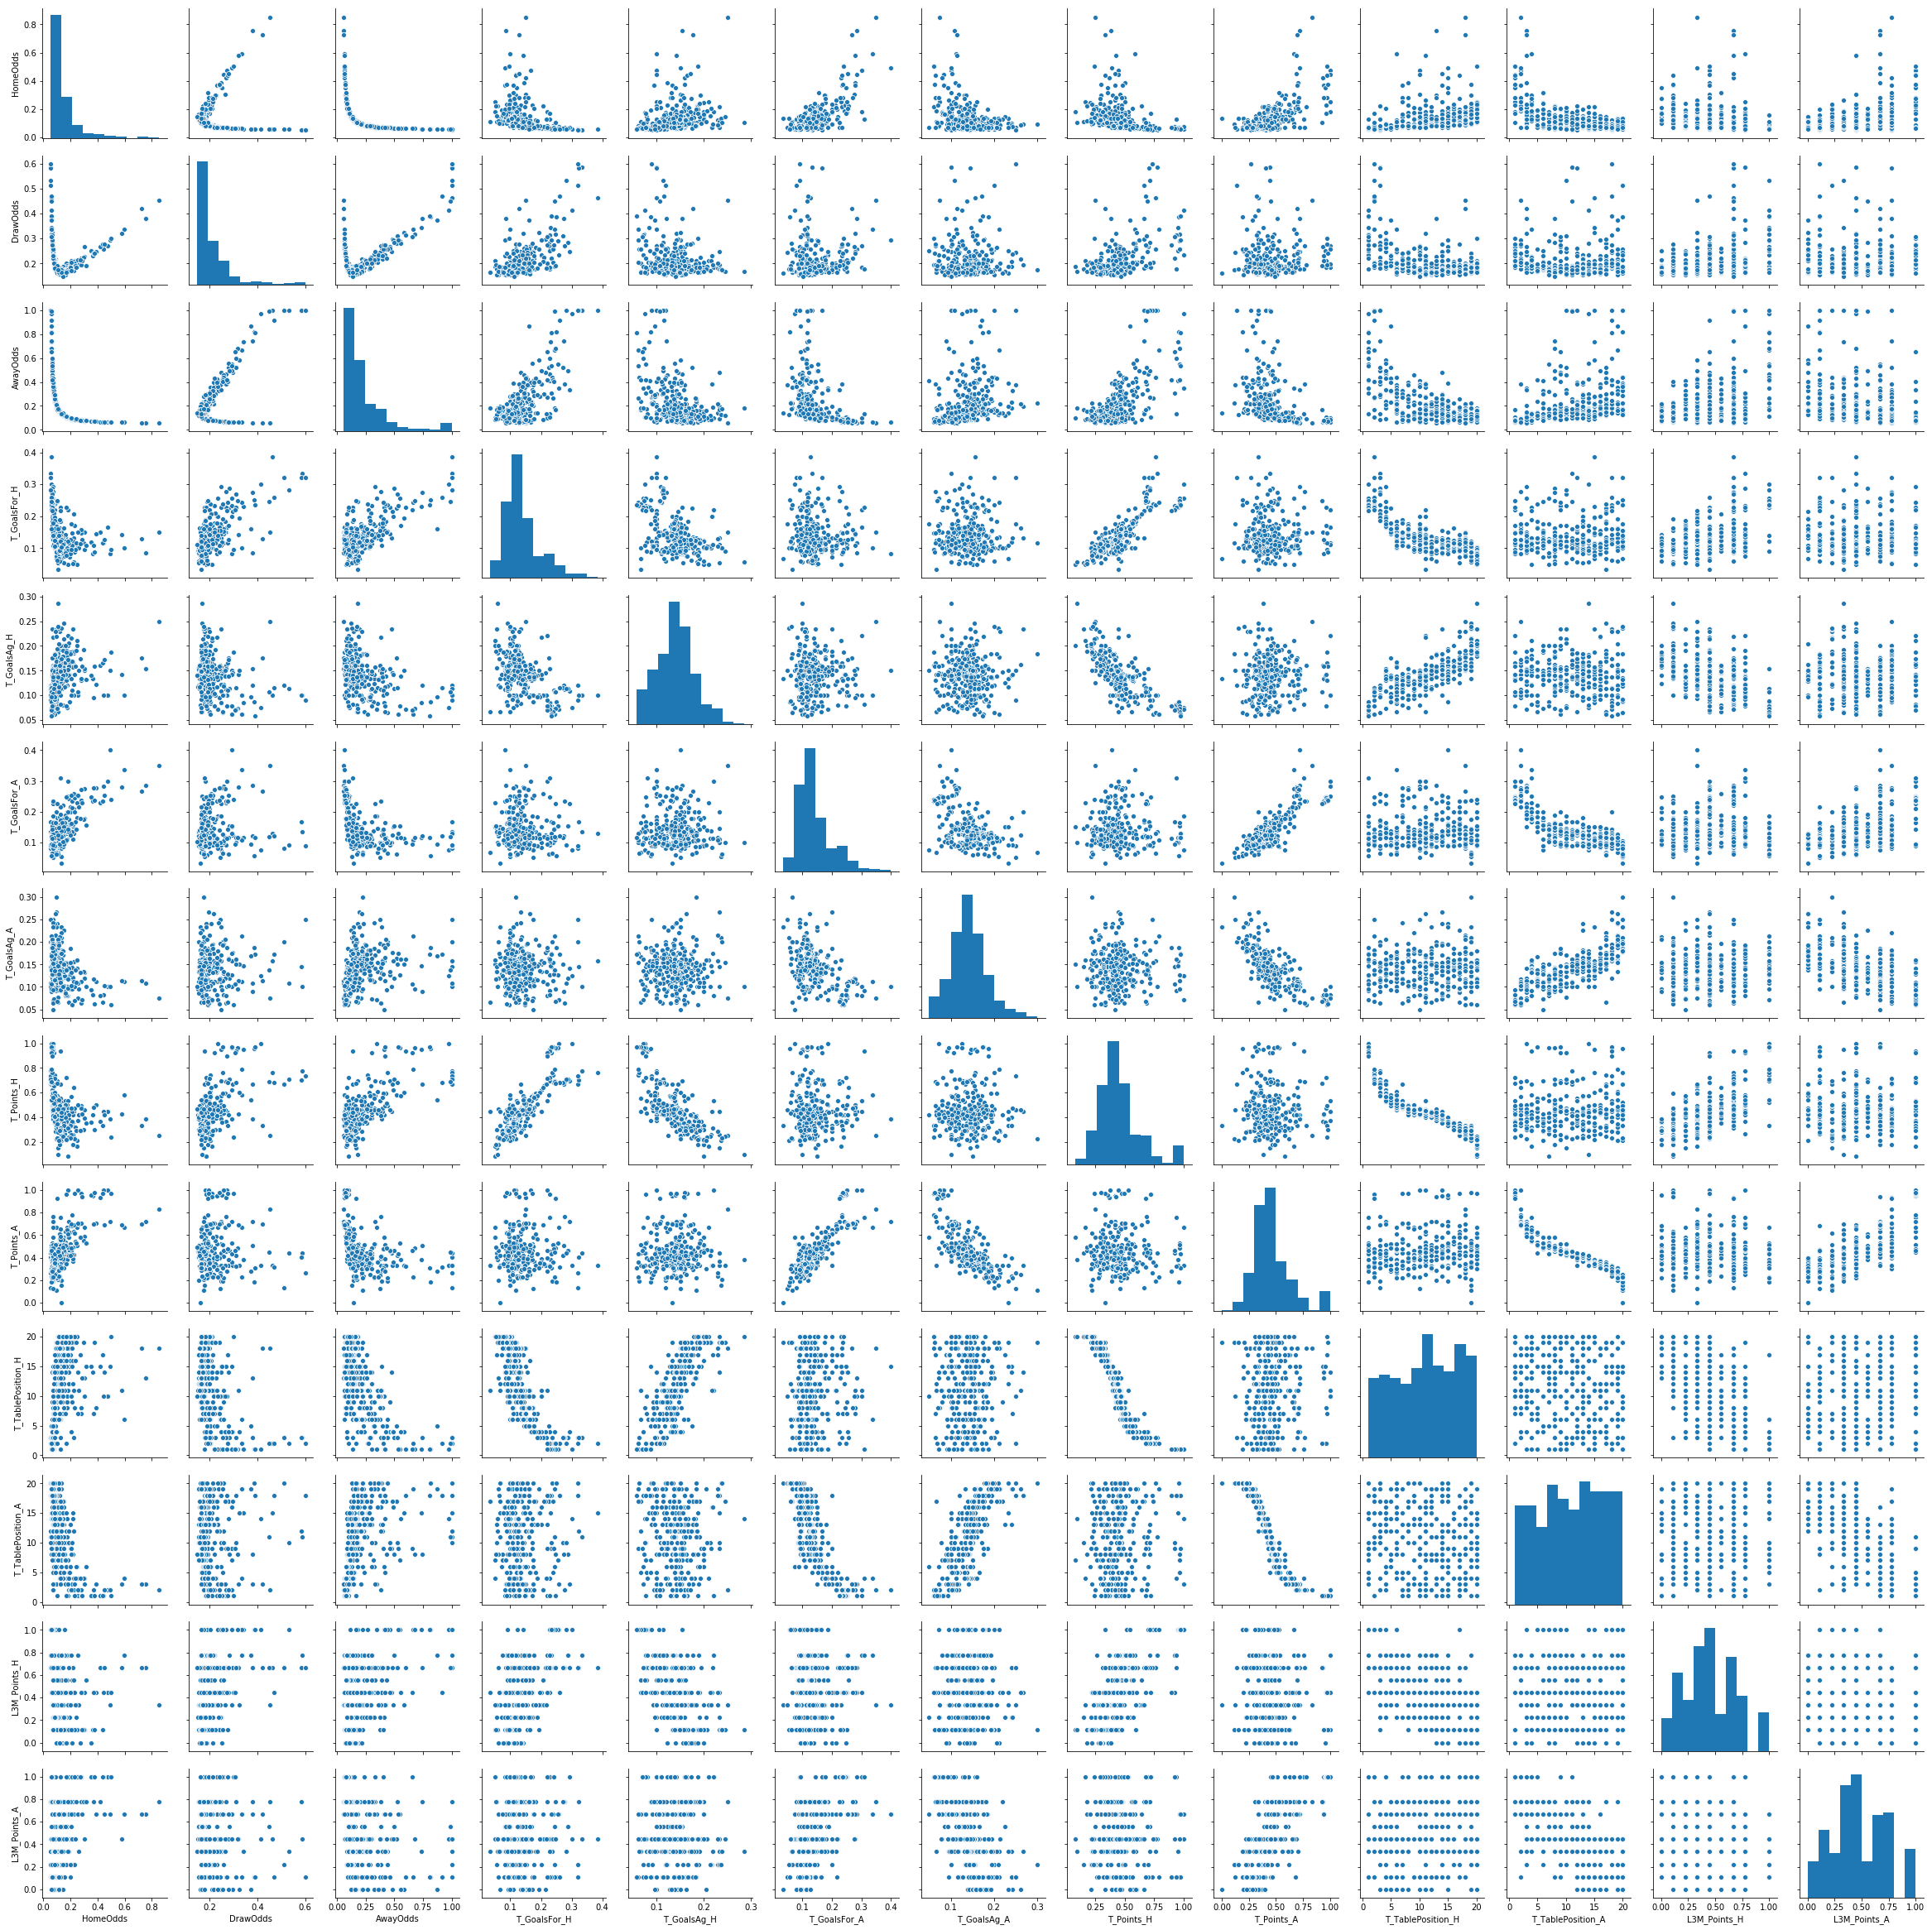

In [13]:
# step 2: quick eda via corrplot

import seaborn as sns
import matplotlib.pyplot as plt
 
sns.pairplot(X_test)
plt.show()

In [2]:
# step 3: train xgb model
# why xgb: it's high performing and not interpretable. we want to use SHAP package later to interpret the model results

import xgboost as xgb
from xgboost import plot_importance, plot_tree
import sklearn
import shap

print(xgb.__version__)

param = {
    'objective': 'reg:squarederror',
    'eta': 0.2
}

num_round = 20

param['scale_pos_weight']= (y_train.size - y_train.sum()) / y_train.sum()

features = X_train.columns.values

xg_train = xgb.DMatrix(
    X_train.values, feature_names = features, label = y_train.values
)
xg_test = xgb.DMatrix(
    X_test.values, feature_names = features, label = y_test.values
)

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
reg = xgb.train(
    param, xg_train, num_round, watchlist, verbose_eval=True
)

preds = reg.predict(xg_test)

1.0.0
[0]	train-rmse:0.40505	test-rmse:0.41460
[1]	train-rmse:0.33704	test-rmse:0.34752
[2]	train-rmse:0.28464	test-rmse:0.29723
[3]	train-rmse:0.24484	test-rmse:0.25976
[4]	train-rmse:0.21486	test-rmse:0.23322
[5]	train-rmse:0.19301	test-rmse:0.21359
[6]	train-rmse:0.17707	test-rmse:0.20018
[7]	train-rmse:0.16563	test-rmse:0.19127
[8]	train-rmse:0.15745	test-rmse:0.18468
[9]	train-rmse:0.15166	test-rmse:0.18075
[10]	train-rmse:0.14749	test-rmse:0.17789
[11]	train-rmse:0.14444	test-rmse:0.17616
[12]	train-rmse:0.14221	test-rmse:0.17481
[13]	train-rmse:0.14056	test-rmse:0.17396
[14]	train-rmse:0.13867	test-rmse:0.17366
[15]	train-rmse:0.13763	test-rmse:0.17361
[16]	train-rmse:0.13660	test-rmse:0.17348
[17]	train-rmse:0.13600	test-rmse:0.17353
[18]	train-rmse:0.13506	test-rmse:0.17414
[19]	train-rmse:0.13431	test-rmse:0.17406


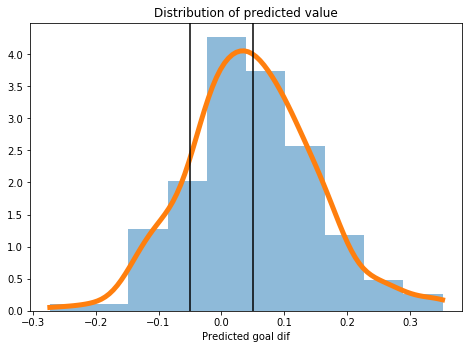

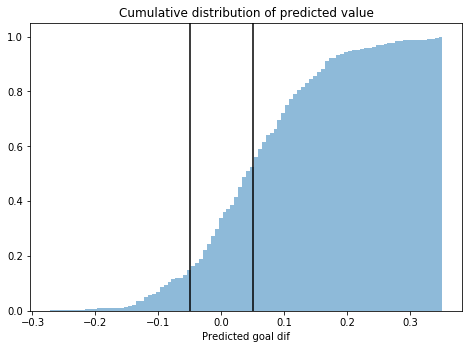

In [3]:
# step 4: visualize distribution of predictions. 
# we want normal distribution, with slight skew towards home wins, which we get

import matplotlib.pyplot as plt
import scipy.stats as st

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

kde_xs = np.linspace(min(preds), max(preds), 100)
kde = st.gaussian_kde(preds)

ax.hist(
    preds,
    alpha=0.5,
#     bins=25,
    density=True
)
ax.plot(
    kde_xs, 
    kde.pdf(kde_xs),
    linewidth=5
)

ax.axvline(x=-0.05, color='black')
ax.axvline(x=0.05, color='black')

plt.xlabel('Predicted goal dif')
plt.title('Distribution of predicted value')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.hist(
    preds,
    bins=100,
    cumulative=True,
    density=True,
    alpha=0.5
)

ax.axvline(x=-0.05, color='black')
ax.axvline(x=0.05, color='black')

plt.xlabel('Predicted goal dif')
plt.title('Cumulative distribution of predicted value')
plt.show()

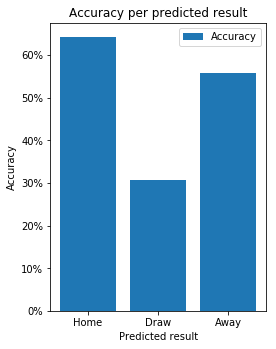

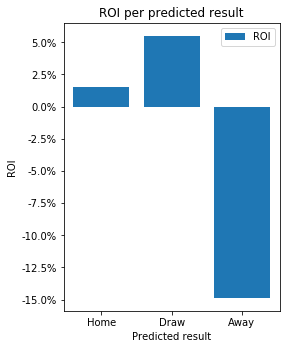

In [4]:
# step 5: visualize accuracy and returns
# we see a positive return on draws mainly and a little bit on home wins, even though draw accuracy is by far the lowest.

import matplotlib.ticker as mtick

preds = reg.predict(xg_test)

preds = [np.clip(int(i),-1,1) for i in np.round(preds*10)]

act = [np.clip(int(i),-1,1) for i in np.round(y_test*10)]

hOdds = X_test.loc[:, 'HomeOdds'].values
dOdds = X_test.loc[:, 'DrawOdds'].values
aOdds = X_test.loc[:, 'AwayOdds'].values

res = {}

for i in range(-1,2):
    res[i] = [0, 0, 0]

for i, j, h, d, a in zip(preds, act, hOdds, dOdds, aOdds):
    if i==j:
        res[i][0] += 1
        
        if i == 1:
            res[i][2] += h*20
        elif i == 0:
            res[i][2] += d*20
        elif i == -1:
            res[i][2] += a*20
        
    res[i][1] += 1
    res[i][2] -= 1
             
        
ret, acc = [], []

for k in res.keys():
    res[k][2] /= res[k][1]
    
    ret.append(res[k][2]*100)
    acc.append(res[k][0]*100/res[k][1])

ret, acc = ret[::-1], acc[::-1]

xlabs = ['Home','Draw','Away']

fig = plt.figure()
ax = fig.add_axes([0,0,0.5,1])

ax.bar(
    xlabs,
    acc,
    label='Accuracy'
)
ax.legend()

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Accuracy')
plt.xlabel('Predicted result')
plt.title('Accuracy per predicted result')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,0.5,1])

ax.bar(
    xlabs,
    ret,
    label='ROI'
)
ax.legend()


ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('ROI')
plt.xlabel('Predicted result')
plt.title('ROI per predicted result')
plt.show()

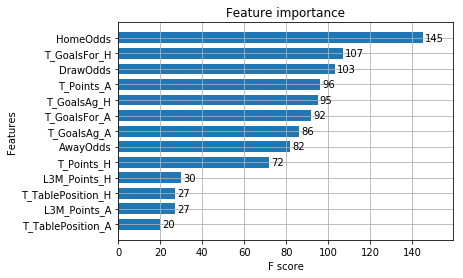

In [5]:
# step 6: feature importance using F score. this is directionless/magnitude feature importance, SHAP will let us understand how each variable affects model output

_ = plot_importance(reg, height=0.7)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


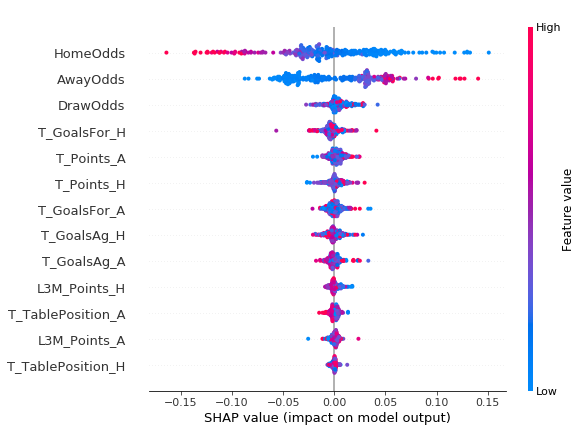

In [6]:
# step 7: summary plot using SHAP

explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

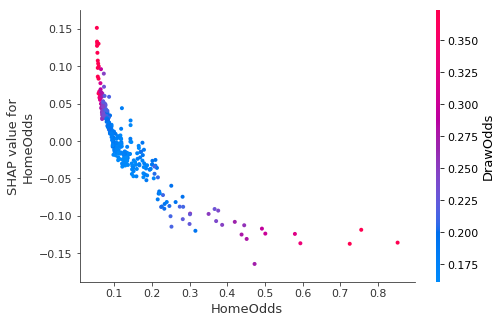

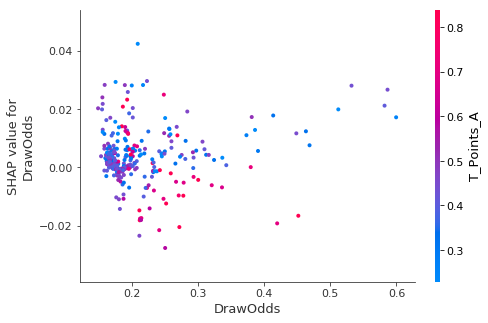

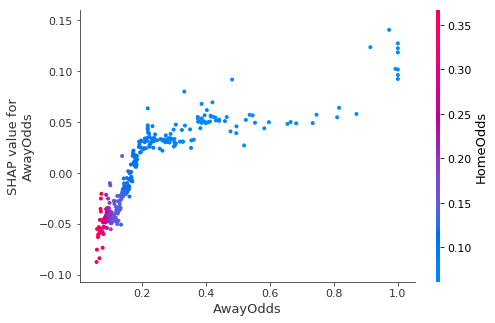

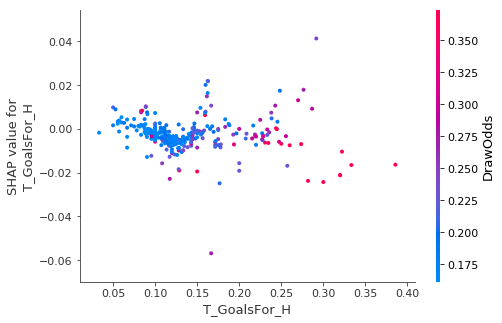

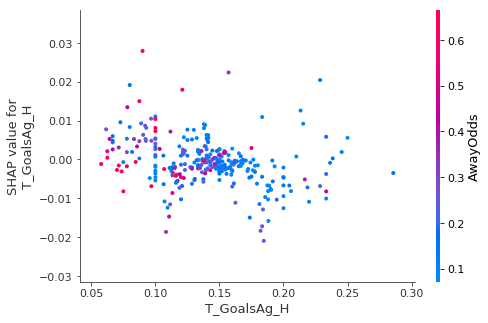

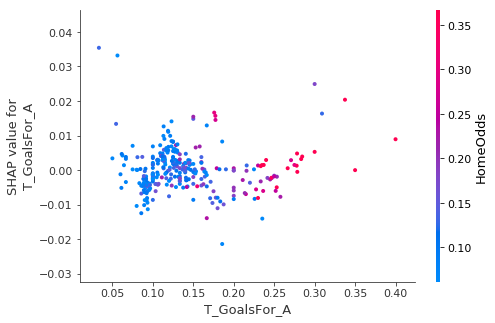

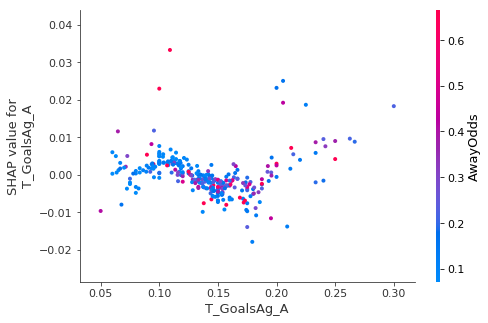

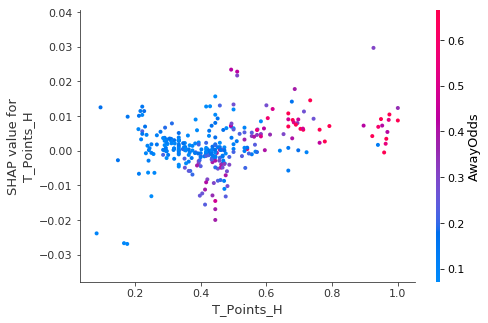

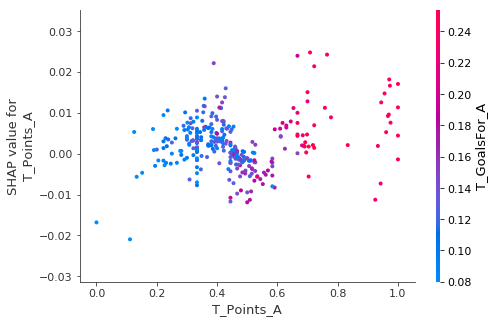

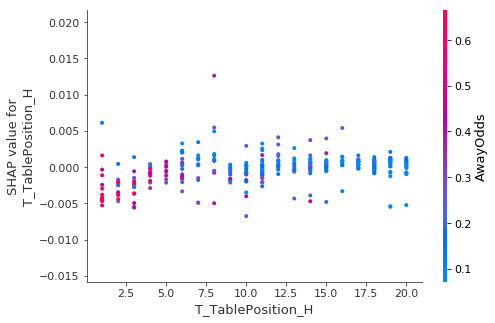

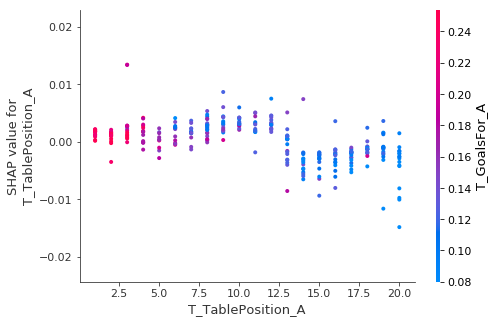

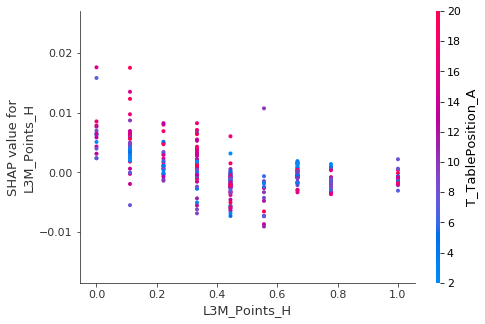

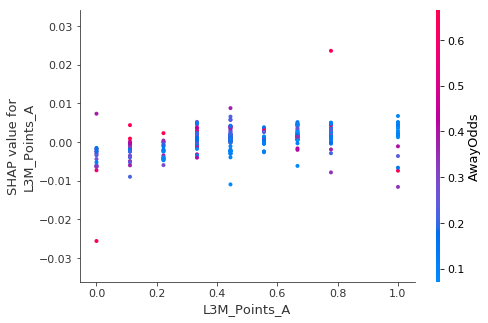

In [7]:
# step 8: SHAP values for each feature

for val in features:
    shap.dependence_plot(val, shap_values, X_test)

In [8]:
# step 9: local explanation examples. we will use these values in the web app to dynamically explain each prediction

shap.initjs()

i = -1

shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i, :])

In [9]:
shap.initjs()

i = -2

shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i, :])

In [10]:
shap.initjs()

i = -3

shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i, :])